# Missteering measurement

Measuring the vertical missteering at C171. Quick measurements seems to show that in this case the analytical law is respected (see PSMD logbook on May 16th).

The calibration for DVT50 from current to angle can be derived by:
```
Finding the current boundaries for DVT50 using YASP:
-400 urad = -4.63 A
-300 urad = -3.82 A
0 urad = -1.39 A
+300 urad = 1.04 A
+400 urad = 1.85 A 
```

**PROBLEM** the vertical wirescaner was set at C181. Measurement to be redone.

In [1]:
%run /eos/project/l/liu/Toolbox/myToolbox.py
print '---'
%run /eos/user/e/esenes/PS-analysis-tools/eTools.py
print '---'
sys.path.append('/eos/project/l/liu/Instrumentation/Scripts')
import metaclass

Version 0.03. This is the latest version.
Please help me to improve it reporting bugs to guido.sterbini@cern.ch.
Your platform is Linux-3.10.0-693.11.6.el7.centos.plus.x86_64-x86_64-with-redhat-6.9-Carbon
Your folder is /eos/user/e/esenes/Injection_missteering/2018.05.16
Your IP is 172.17.0.11
2018-05-23 10:48:31
---
Version 0.1
Use at your own risk. Please report bugs to eugenio.senes@cern.ch
Fork it at https://gitlab.cern.ch/esenes/PS-analysis-tools
---


In [2]:
sys.path.append('/eos/project/l/liu/Instrumentation/Scripts')
import metaclass

# User inputs

In [3]:
folderPath = '/eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.05.16'

matlabVars = ['PR_BWS_65_H_ROT.Acquisition.value.projDataSet1', # Wirescanner 65
                'PR_BWS_65_H_ROT.Acquisition.value.projPositionSet1',
                'PR_BWS_65_H_ROT.Acquisition.value.acqTimeInCycleSet1',
                'PR_BWS_85_V_ROT.Acquisition.value.projDataSet1', # Wirescanner 85
                'PR_BWS_85_V_ROT.Acquisition.value.projPositionSet1',
                'PR_BWS_85_V_ROT.Acquisition.value.acqTimeInCycleSet1',
                'logical_PI_KFA45.K.value', # Kicker k parameter value (mrad)
                'PI_KFA45.AQN1.value',
                'PI_KFA45.CCV.value', 
                'PR_BPM.AcquisitionOrbit.value.position', # BPMs
                'PR_BPM.AcquisitionTrajectoryBBB.value.position',
                'PR_BCT_ST.Samples.value.samples']



In [4]:
# let's start with the matlab data
files = sorted(glob.glob(folderPath+'/data/2018*.mat'))
print 'Found ' + str(len(files)) + ' data files'
print 'First: ' + files[0]
print 'End: ' + files[-1]

Found 110 data files
First: /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.05.16/data/2018.05.16.15.01.58.102.mat
End: /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.05.16/data/2018.05.16.16.09.32.973.mat


In [5]:
myDataFrame = myToolbox.fromMatlabToDataFrame(files,matlabVars,verbose=False)

# Data cleanup

In [6]:
myDataFrame = checkDuplicates(myDataFrame) # Drop double acquisitions from matlab
myDataFrame = checkBPMData(myDataFrame) # BPMs fault
# manual data drop
# myDataFrame = myDataFrame.drop(myDataFrame.loc['2017-11-14 17:58:45.100000'].name) # X wirescanner fault
# myDataFrame = myDataFrame.drop(myDataFrame.loc['2017-11-14 17:59:28.300000'].name) # non-phys emittance

No duplicates found
---
BPM data ok
---


# Load the DVT50 current settings 
Different files because comes from the PSB monitor

In [7]:
folderPath = '/eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.05.16/data_PSB/'

matlabVars = ['AQN.current', # DVT50
                'CCV.current']

# let's start with the matlab data
files = sorted(glob.glob(folderPath+'/PSB2018*.mat'))
print 'Found ' + str(len(files)) + ' data files'
print 'First: ' + files[0]
print 'End: ' + files[-1]

AQN_DVT50 = np.empty(len(files),dtype=float)
CCV_DVT50 = np.empty(len(files),dtype=float)

for k in range(len(files)):
    AQN_DVT50[k] = scipy.io.loadmat(files[k])['AQN'][0][0][0][0][0]
    CCV_DVT50[k] = scipy.io.loadmat(files[k])['CCV'][0][0][0][0][0]

Found 110 data files
First: /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.05.16/data_PSB/PSB2018.05.16.15.01.58.216.mat
End: /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.05.16/data_PSB/PSB2018.05.16.16.09.33.068.mat


In [8]:
myDataFrame['AQN_DVT50'] = AQN_DVT50
myDataFrame['CCV_DVT50'] = CCV_DVT50

# Import the optics model

In [9]:
# get the optics functions from the model
optics = metaclass.twiss('/eos/user/e/esenes/AnalysisTools/Injection7_optics_Qx_0.21_Qy_0.23.outx')

Problem parsing: @ ORBIT_-CT        %le   -0.00000000

Going to be parsed as string
Problem persits, let's ignore it!


# Booster emittance

In [16]:
emix_norm_PSB = 2.484
emiy_norm_PSB = 2.076

emix_geom_PSB = emix_norm_PSB/(betar*gammar)
emiy_geom_PSB = emiy_norm_PSB/(betar*gammar)

# Match the tomogram data

In [12]:
# directly copied from one of Guido's analyses
def extractProfile(fileName):
    '''Give me the input file (.dat) of the tomogram and I will give you 2 output:
        the deltaP_P and the the momentum distribution profile.
    ''' 

    print('/eos/project/l/liu/Instrumentation/tomography/runofflinetomo ' + fileName)
    a=os.system('/eos/project/l/liu/Instrumentation/tomography/runofflinetomo ' + fileName)
    
    convergence=np.loadtxt(fileName[0:-4] + '/d001.data')
    image=np.loadtxt(fileName[0:-4] + '/image001.data')
    with open(fileName[0:-4] + '/input_v2.dat','r') as stream: tomofileheader = stream.readlines()[:98]

    myInput={'PLSUSER': tomofileheader[0][0:-1],
            'NumberOfframes': np.int(tomofileheader[16][0:-1]),
            'B_T': np.double(tomofileheader[75][0:-1]),
            'Bdot_T_per_s': np.double(tomofileheader[77][0:-1]),
            'machineRadius_m': np.double(tomofileheader[79][0:-1]),
            'bendingRadius_m': np.double(tomofileheader[81][0:-1]),
            'particleMass_eV': np.double(tomofileheader[85][0:-1]),
            'h': np.int(np.double(tomofileheader[69][0:-1])),
            'ctime': np.int(tomofileheader[2]),
            'cycleStamp':np.int(tomofileheader[1]),                    # cyclestamp in unix time
            'pickupSensitivity':np.double(tomofileheader[97])          # pickup sensitivity
    }

    with open(fileName[0:-4] + '/plotinfo.data','r') as stream: tomofileheader = stream.readlines()

    myInput['profilecount']=np.int(str.split(tomofileheader[1])[2])
    myInput['profilelength']=np.int(str.split(tomofileheader[3])[2])

    myInput['dtbin']=np.double(str.split(tomofileheader[5])[2])
    myInput['dEbin']=np.double(str.split(tomofileheader[7])[2])
    myInput['xat0']=np.double(str.split(tomofileheader[11])[2])
    myInput['yat0']=np.double(str.split(tomofileheader[12])[2])
    myInput['eperimage']=np.double(str.split(tomofileheader[9])[2])

    mySpeedOfLight=299792458. #TODO
    myInput['momentum_eV']=myInput['B_T']*myInput['bendingRadius_m']/(10/mySpeedOfLight*1e8)*1.e9 #TODO
    myInput['totalEnergy_eV']=np.sqrt(myInput['momentum_eV']**2+myInput['particleMass_eV']**2)
    myInput['gamma']=myInput['totalEnergy_eV']/myInput['particleMass_eV']
    myInput['beta']=np.sqrt(1-1/myInput['gamma']**2)

    image=image*myInput['eperimage']/myInput['dtbin']/myInput['dEbin']

    halfProfileLength=myInput['profilelength']/2.

    Toffset= (myInput['xat0']-halfProfileLength)*myInput['dtbin']*1e9
    Eoffset= (myInput['yat0']-halfProfileLength)*myInput['dEbin']/1e6

    t=np.arange(-halfProfileLength,halfProfileLength)*myInput['dtbin']*1e9-Toffset
    E=np.arange(-halfProfileLength,halfProfileLength)*myInput['dEbin']/1e6-Eoffset


    deltaP_P= 1/myInput['beta']**2*E*1e6/myInput['totalEnergy_eV']
    myProfile=np.sum(np.reshape(image, [myInput['profilelength'], myInput['profilelength']]),0)
    myProfile=myProfile/np.trapz(myProfile,deltaP_P)
    myInput['deltaP_P']=deltaP_P;
    myInput['myProfile']=myProfile;
    myInput['E_MeV']=E
    myInput['t_ns']=t
    myInput['phaseSpace_e_per_eVs']=np.reshape(image, [myInput['profilelength'], myInput['profilelength']]);
    myProfileNormalized=myProfile/np.trapz(myProfile,deltaP_P)
    myMean=np.trapz(deltaP_P*myProfileNormalized,deltaP_P)
    myRMS=np.sqrt(np.trapz((deltaP_P-myMean)**2*myProfileNormalized,deltaP_P))
    myInput['deltaP_P_RMS']=myRMS
    return myInput

In [13]:
# new tomogram analysis
folderPath = '/eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.05.16/'
files_tomo=sorted(glob.glob(folderPath+'/tomo_data/*.dat'))

tomo_data = pnd.DataFrame()

for f in range(len(files_tomo)):
    try:
        tomo_d = extractProfile(files_tomo[f])
        tomo_d['Filename'] = files_tomo[f]
        if tomo_d is np.nan:
            pass
        else:
            tomo_data=tomo_data.append(tomo_d,ignore_index=True)
    except IOError:
        print '\nIOError\n'

/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.05.16//tomo_data/injall_001.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.05.16//tomo_data/injall_002.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.05.16//tomo_data/injall_003.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.05.16//tomo_data/injall_004.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.05.16//tomo_data/injall_005.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.05.16//tomo_data/injall_006.dat
/eos/project/l/liu/Instrumen

/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.05.16//tomo_data/injall_052.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.05.16//tomo_data/injall_053.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.05.16//tomo_data/injall_054.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.05.16//tomo_data/injall_055.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.05.16//tomo_data/injall_056.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.05.16//tomo_data/injall_057.dat
/eos/project/l/liu/Instrumen

/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.05.16//tomo_data/injall_103.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.05.16//tomo_data/injall_104.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.05.16//tomo_data/injall_105.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.05.16//tomo_data/injall_106.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.05.16//tomo_data/injall_107.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.05.16//tomo_data/injall_108.dat
/eos/project/l/liu/Instrumen

In [14]:
timeTolerance = 15

# ---------- Vars initialisation
myDataFrame['tomoTimestamp']=np.nan
myDataFrame['tomoDelta']=np.nan
myDataFrame['tomoFilename']=np.str
myDataFrame['deltaP_P_rms']=np.nan
myDataFrame['peakLineDensity']=np.nan
myDataFrame['beta']=np.nan
myDataFrame['gamma']=np.nan
myDataFrame['deltaP_P']=[np.empty(0,dtype=float)]*len(myDataFrame)
myDataFrame['momentumProfile']=[np.empty(0,dtype=float)]*len(myDataFrame)


succ_count = 0
last_match = 0
# loop over the tomo_timestamps
for k in range(len(tomo_data)):
    tomo_local_cs = tomo_data['cycleStamp'].values[k]
    t = myToolbox.unixtime2datetime(tomo_local_cs)
    tomo_fname = tomo_data['Filename'].iloc[k]
    tomo_dpprms = tomo_data['deltaP_P_RMS'].iloc[k]
#     tomo_pkldens = tomo_data['peakLineDensity'].iloc[k]
    betar = tomo_data['beta'].iloc[k]
    gammar = tomo_data['gamma'].iloc[k]
    dpp_profil = tomo_data['deltaP_P'].iloc[k]
    p_profil = tomo_data['myProfile'].iloc[k]    


    # loop over the matlab data
    for x in range(len(myDataFrame)):
        c = myToolbox.unixtime2utcdatetime(myDataFrame['cycleStamp'].values[x]*1e-9)
        d = t-c
        d = d.total_seconds()

        if np.abs(d) <= timeTolerance and x > last_match: #avoid match the same tomogram to more matlab acquisition unintentionally
            myDataFrame['tomoTimestamp'].iloc[x] = tomo_local_cs
            myDataFrame['tomoFilename'].iloc[x] = tomo_fname
            myDataFrame['tomoDelta'].iloc[x] = d
            myDataFrame['deltaP_P_rms'].iloc[x]= tomo_dpprms
#             myDataFrame['peakLineDensity'].iloc[x]= tomo_pkldens
            myDataFrame['beta'].iloc[x]= betar
            myDataFrame['gamma'].iloc[x]= gammar
            myDataFrame['deltaP_P'].iloc[x]= dpp_profil
            myDataFrame['momentumProfile'].iloc[x]= p_profil


            succ_count += 1 #dummy counter
            
print str(succ_count) +"/"+ str(len(tomo_data)) +" are within the timeTolerance"
print 'length of dataframe is: '+ str(len(myDataFrame)) 

/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-slc6-gcc62-opt/lib/python2.7/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


109/131 are within the timeTolerance
length of dataframe is: 110


In [15]:
# discard the elements without tomogram
discFlag = np.isnan(myDataFrame['tomoDelta'].values)
myDataFrame = myDataFrame.drop(myDataFrame.loc[discFlag].index)

# Save the imported data

In [17]:
myDataFrame.to_pickle('imported_data_2018.05.16.pkl')

In [82]:
# myDataFrame=pnd.read_pickle('imported_data_2018.05.16.pkl')

# Intensity

In [18]:
myDataFrame['Intensity'] = myDataFrame['PR_BCT_ST.Samples.value.samples']
myDataFrame['Losses'] = myDataFrame['Intensity'].apply(lambda x: 1-x[:][100]/np.max(x) )

Text(0,0.5,u'Peak intensity (10^10 ppb)')

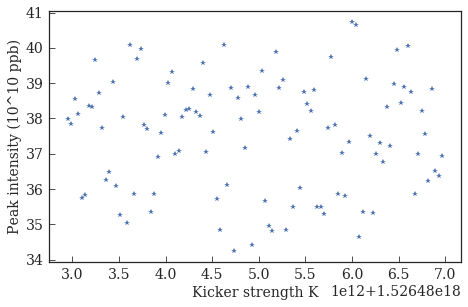

In [19]:
plt.plot(myDataFrame['Intensity'].apply(lambda x: np.max(x)),'*')
plt.xlabel('Kicker strength K')
plt.ylabel('Peak intensity (10^10 ppb)')

Text(0,0.5,u'Losses')

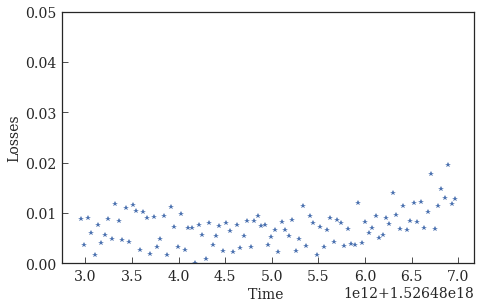

In [20]:
plt.plot(myDataFrame['Losses'],'*')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,0,0.05))
plt.xlabel('Time ')
plt.ylabel('Losses')

Text(0.5,1,u'10 shots intensity')

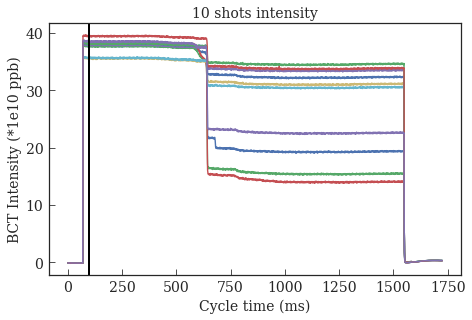

In [21]:
for ll in range(10):
    plt.plot(myDataFrame['Intensity'].values[ll])
    
plt.axvline(x=100, ymin=0, ymax = 8, linewidth=2, color='k')
plt.xlabel('Cycle time (ms)')
plt.ylabel('BCT Intensity (*1e10 ppb)')
plt.title('10 shots intensity')

# Calculate wire scanner emittance
## X plane
### Traditional method

In [22]:
# Wirescanner sigma
#position data cleanup (sort, get unique values and the idxes) and conversion to mm
myDataFrame['BWS65_position'] = myDataFrame['PR_BWS_65_H_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[0]*1e-3)
myDataFrame['BWS65_position_idx'] = myDataFrame['PR_BWS_65_H_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[1])

#instantiate an array object for the result in the frame
myDataFrame['BWS65_data'] = myDataFrame['BWS65_position_idx'].apply(lambda x: np.empty(len(x)))
pos = np.arange(-50, 50, 0.05)

row, col = myDataFrame.shape

for r in xrange(row):
    myDataFrame['BWS65_data'].iloc[r] = np.interp(pos, myDataFrame['BWS65_position'].iloc[r], myDataFrame['PR_BWS_65_H_ROT.Acquisition.value.projDataSet1'].iloc[r][myDataFrame['BWS65_position_idx'].iloc[r]])  
    
#do the fit and get the sigma in mm
myDataFrame['WS_fit_results_x'] = myDataFrame['BWS65_data'].apply(lambda x: myToolbox.makeGaussianFit_5_parameters(pos,x))
myDataFrame['WS_sigma_x'] = myDataFrame['WS_fit_results_x'].apply(lambda x: x[0][-1])


In [23]:
# Emittance calculation
myDataFrame['WS_emittance_x'] = np.nan
myDataFrame['WS_geom_emittance_x'] = np.nan

for n in range(len(myDataFrame)):
    myDataFrame['WS_emittance_x'].iloc[n] = normalised_emittance('65H',myDataFrame['WS_sigma_x'].values[n],dp=myDataFrame['deltaP_P_rms'].values[n])
    myDataFrame['WS_geom_emittance_x'].iloc[n] = myDataFrame['WS_emittance_x'].iloc[n]/(myDataFrame['beta'].iloc[n]*myDataFrame['gamma'].iloc[n])

### Dispersive profile deconvolution

In [24]:
# BWS65
betax = 21.77988929
Dx = 3.24577470

betax = 20.11
Dx = 3.2

def deconv_caller(row):
    return myToolbox.computeTransverseEmittance(row['PR_BWS_65_H_ROT.Acquisition.value.projPositionSet1'],
                              row['PR_BWS_65_H_ROT.Acquisition.value.projDataSet1'],
                              row['momentumProfile'],
                              row['deltaP_P'],
                              row['beta']*row['gamma'],
                              betaOptical_m=betax,Dispersion_m=Dx)

myDataFrame['Deconvolution_result'] = myDataFrame.apply(deconv_caller,axis=1)



for k in myDataFrame.index:  
    myDataFrame.loc[k,'Emittance_x_deconv'] = myDataFrame.loc[k,('Deconvolution_result')]['emittance_um']


## Y plane

In [25]:
# Wirescanner sigma
#position data cleanup (sort, get unique values and the idxes) and conversion to mm
myDataFrame['BWS85_position'] = myDataFrame['PR_BWS_85_V_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[0]*1e-3)
myDataFrame['BWS85_position_idx'] = myDataFrame['PR_BWS_85_V_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[1])

#instantiate an array object for the result in the frame
myDataFrame['BWS85_data'] = myDataFrame['BWS85_position_idx'].apply(lambda x: np.empty(len(x)))
pos = np.arange(-50, 50, 0.05)

row, col = myDataFrame.shape

for r in xrange(row):
    myDataFrame['BWS85_data'].iloc[r] = np.interp(pos, myDataFrame['BWS85_position'].iloc[r], myDataFrame['PR_BWS_85_V_ROT.Acquisition.value.projDataSet1'].iloc[r][myDataFrame['BWS85_position_idx'].iloc[r]])  

#do the fit and get the sigma in mm
myDataFrame['WS_fit_results_y'] = myDataFrame['BWS85_data'].apply(lambda x: myToolbox.makeGaussianFit_5_parameters(pos,x))
myDataFrame['WS_sigma_y'] = myDataFrame['WS_fit_results_y'].apply(lambda x: x[0][-1])

/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-slc6-gcc62-opt/lib/python2.7/site-packages/scipy/optimize/minpack.py:715: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [26]:
# Emittance calculation
myDataFrame['WS_emittance_y'] = myDataFrame['WS_sigma_y'].apply(lambda x: normalised_emittance('85V',x))

myDataFrame['WS_geom_emittance_y'] = np.nan
for n in range(len(myDataFrame)):
    myDataFrame['WS_geom_emittance_y'].iloc[n] = myDataFrame['WS_emittance_y'].iloc[n]/(myDataFrame['beta'].iloc[n]*myDataFrame['gamma'].iloc[n])

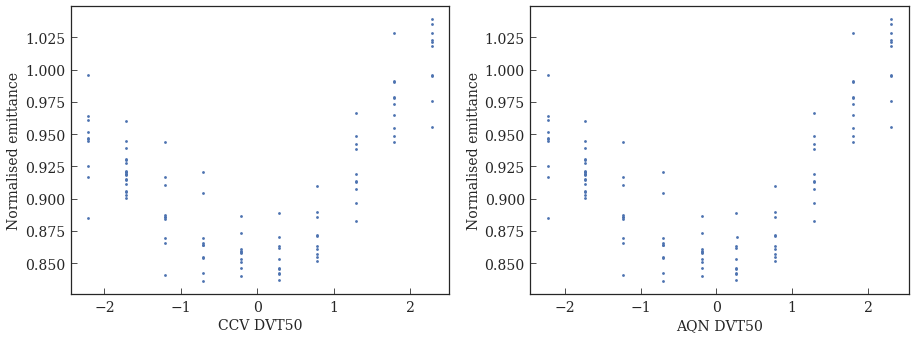

In [51]:
fig, ax = plt.subplots(1,2,figsize=(13,5))

ax[0].plot(myDataFrame['CCV_DVT50'], myDataFrame['WS_emittance_y'],'.' )
ax[0].set_xlabel('CCV DVT50')
ax[0].set_ylabel('Normalised emittance')

ax[1].plot(myDataFrame['AQN_DVT50'], myDataFrame['WS_emittance_y'],'.' )
ax[1].set_xlabel('AQN DVT50')
ax[1].set_ylabel('Normalised emittance')

fig.tight_layout()

## Find a calibration curve for current --> angle of DVT50

In [49]:
# 1) the variation speed is preserved and is the slope of the reference curve
#data from YASP
angle = np.array([-0.4e-3,-0.3e-3,0.,0.3e-3,0.4e-3],dtype=float) 
current = np.array([-4.63,-3.82,-1.39,1.04,1.85],dtype=float)

#interpolation
params = np.polyfit(current,angle,1)
slope = params[0]

Model function: a(x - b)^2 + c
Fit params: a=0.0242725462678 b= -0.235320880154 c= 0.859587467528

So the zero kick setting in our measurements was -0.235320880154 A


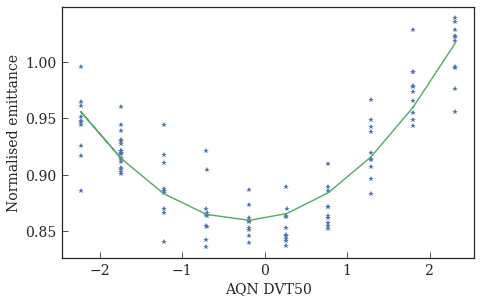

In [69]:
# 2) find the zero in our settings
from scipy.optimize import curve_fit

def f_to_fit(x, a, b, c):
    return a*(x - b)**2 + c

xdata = myDataFrame['AQN_DVT50']
ydata = myDataFrame['WS_emittance_y']

fig, ax = plt.subplots(1)
ax.plot(xdata, ydata,'*')
ax.set_xlabel('AQN DVT50')
ax.set_ylabel('Normalised emittance')

p, cov = curve_fit(f_to_fit,xdata,ydata)
ax.plot(xdata, f_to_fit(xdata,*p))

print 'Model function: a(x - b)^2 + c'
print 'Fit params: a=' + str(p[0]) + ' b= ' + str(p[1]) + ' c= '+ str(p[2])

print('\nSo the zero kick setting in our measurements was '+str(p[1])+' A')
currZero = p[1]

In [153]:
# 3) and now the calibration curve is 
def currentToAngle(current):
    a = -slope*currZero
    print(a)
    print(slope)
    return a + (slope*current)

myDataFrame['DVT50_kick'] = currentToAngle(myDataFrame['AQN_DVT50'])

2.90519605128e-05
0.000123456790123


Text(0,0.5,u'Normalised emittance (um)')

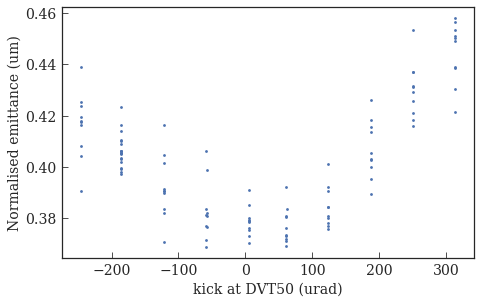

In [91]:
# so now in kick units
fig, ax = plt.subplots(1)

ax.plot(1e6*myDataFrame['DVT50_kick'], myDataFrame['WS_geom_emittance_y'],'.' )
ax.set_xlabel('kick at DVT50 (urad)')
ax.set_ylabel('Normalised emittance (um)')

## Calculate average emittance per measurement point

In [99]:
# find indexes of the shots at the same kick
ks = []
ks_idx = []
for k in range(len(myDataFrame)):
    if k == 0 :
        prevk = myDataFrame['DVT50_kick'].iloc[k]
        ks.append(prevk)
        ks_idx.append(k)
        continue
#     print(k)
    
    thisk = myDataFrame['DVT50_kick'].iloc[k]
    if (prevk-thisk) != 0:
#         print(thisk)
        ks.append(thisk)
        ks_idx.append(k)
    prevk = thisk

In [106]:
# manual adjusting
ks_idx = [0, 9, 19, 29, 39, 49, 59, 69, 79, 89, 99]

In [112]:
k_values = np.array((myDataFrame['DVT50_kick'].iloc[ks_idx]))

emix_mean = np.empty(len(ks_idx),dtype=float)
emiy_mean = np.empty(len(ks_idx),dtype=float)
emix_std = np.empty(len(ks_idx),dtype=float)
emiy_std = np.empty(len(ks_idx),dtype=float)


for k in range(len(ks_idx)):
    if k==len(ks_idx)-1:
        emix_mean[k] = np.mean(myDataFrame['WS_geom_emittance_x'].iloc[ks_idx[k]:]) # the last tranche to close the array
        emiy_mean[k] = np.mean(myDataFrame['WS_geom_emittance_y'].iloc[ks_idx[k]:]) # the last tranche to close the array
        emix_std[k] = np.std(myDataFrame['WS_geom_emittance_x'].iloc[ks_idx[k]:]) # the last tranche to close the array
        emiy_std[k] = np.std(myDataFrame['WS_geom_emittance_y'].iloc[ks_idx[k]:]) # the last tranche to close the array
    else:
        emix_mean[k] = np.mean(myDataFrame['WS_geom_emittance_x'].iloc[ks_idx[k]:ks_idx[k+1]]) 
        emiy_mean[k] = np.mean(myDataFrame['WS_geom_emittance_y'].iloc[ks_idx[k]:ks_idx[k+1]]) 
        emix_std[k] = np.std(myDataFrame['WS_geom_emittance_x'].iloc[ks_idx[k]:ks_idx[k+1]]) 
        emiy_std[k] = np.std(myDataFrame['WS_geom_emittance_y'].iloc[ks_idx[k]:ks_idx[k+1]])



In [113]:
k_values

array([ -1.85603144e-04,  -2.45899586e-04,  -1.85603144e-04,
        -1.22291974e-04,  -5.83777955e-05,   6.13933534e-06,
         6.16120132e-05,   1.24320242e-04,   1.88234421e-04,
         2.50942628e-04,   3.14253857e-04])

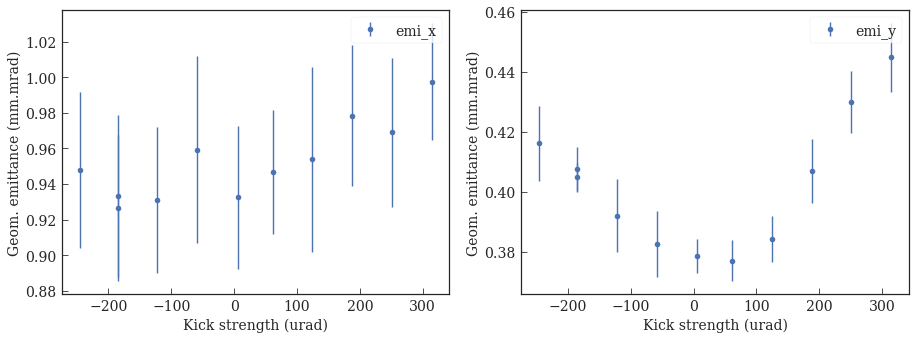

In [123]:
fig, ax = plt.subplots(1,2,figsize=(13,5))

ax[0].errorbar(1e6*k_values, emix_mean, yerr=emix_std, fmt='o',label='emi_x')
ax[0].set_xlabel('Kick strength (urad)')
ax[0].set_ylabel('Geom. emittance (mm.mrad)')
ax[0].legend(frameon=True)

ax[1].errorbar(1e6*k_values, emiy_mean, yerr=emiy_std, fmt='o',label='emi_y')
ax[1].set_xlabel('Kick strength (urad)')
ax[1].set_ylabel('Geom. emittance (mm.mrad)')
ax[1].legend(frameon=True)

fig.tight_layout()

fig.savefig('Vert_steering_emi_xy.eps', format='eps',dpi=100)

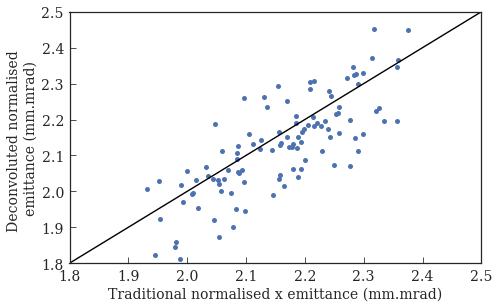

In [127]:
fig2, ax2 = plt.subplots(1)
ax2.plot(myDataFrame['WS_emittance_x'],myDataFrame['Emittance_x_deconv'],'.',markersize=10)
plt.xlabel('Traditional normalised x emittance (mm.mrad)')
plt.ylabel('Deconvoluted normalised \nemittance (mm.mrad)')

ax2.plot([.5,10.],[.5,10.],'-k')
x1,x2,y1,y2 = plt.axis()
plt.axis((1.8,2.5,1.8,2.5))

fig2.savefig('BCMS_under_coupling_Wemi_vs_deconv.eps', format='eps')

Model function: a(x - b)^2 + c
Fit params: a=0.744126541874 b= 4.73923537094e-06 c= 3.77780575831e-07


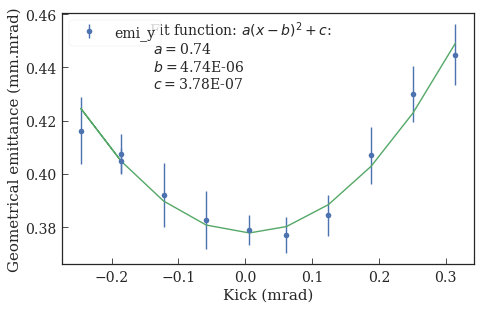

In [147]:
from scipy.optimize import curve_fit

def f_to_fit(x, a, b, c):
    return a*(x - b)**2 + c

xdata = k_values
ydata = 1e-6*emiy_mean

fig, ax = plt.subplots(1)
ax.errorbar(1e3*k_values, emiy_mean, yerr=emiy_std, fmt='o',label='emi_y')

p, cov = curve_fit(f_to_fit,xdata,ydata,sigma=emiy_std)
# xfit = np.linspace(np.min(xdata),np.max(xdata),200)
ax.plot(1e3*xdata, 1e6*f_to_fit(xdata,*p))


#fit and plot fit
print 'Model function: a(x - b)^2 + c'
print 'Fit params: a=' + str(p[0]) + ' b= ' + str(p[1]) + ' c= '+ str(p[2])


plt.xlabel('Kick (mrad)',fontsize=15)
plt.ylabel('Geometrical emittance (mm.mrad)',fontsize=15)

ax.text(0.21, 0.98, 'Fit function: $a(x-b)^2+c$:\n $a=$%.2f \n $b=$%.2E \n $c=$%.2E'%(p[0],p[1],p[2]),
        transform=ax.transAxes, fontsize=14,verticalalignment='top')

x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,0.7,2.3))
plt.legend(frameon=True)

fig.savefig('emi_xy_fitC171.eps', format='eps',dpi=100)

# BPMs

In [30]:
# BPMs
#add field for the first two turns and splitting x and y pickups
myDataFrame['BPMx_turn1'] = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: x[0:43,0])
myDataFrame['BPMy_turn1'] = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: x[-43:,0])
myDataFrame['BPMx_turn2'] = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: x[0:43,1])
myDataFrame['BPMy_turn2'] = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: x[-43:,1])
# #turn to millimiters and cast in float
myDataFrame['BPMx_turn1'] = myDataFrame['BPMx_turn1'].apply(lambda x: x/10.)
myDataFrame['BPMy_turn1'] = myDataFrame['BPMy_turn1'].apply(lambda x: x/10.)
myDataFrame['BPMx_turn2'] = myDataFrame['BPMx_turn2'].apply(lambda x: x/10.)
myDataFrame['BPMy_turn2'] = myDataFrame['BPMy_turn2'].apply(lambda x: x/10.)
# #add orbit
myDataFrame['Orbit_x'] = myDataFrame['PR_BPM.AcquisitionOrbit.value.position'].apply(lambda x: x[0:43,1])
myDataFrame['Orbit_y'] = myDataFrame['PR_BPM.AcquisitionOrbit.value.position'].apply(lambda x: x[-43:,1])
myDataFrame['Orbit_x'] = myDataFrame['Orbit_x'].apply(lambda x: x/10.)
myDataFrame['Orbit_y'] = myDataFrame['Orbit_y'].apply(lambda x: x/10.)

In [31]:
# get the optics functions from the model
optics = metaclass.twiss('/eos/user/e/esenes/AnalysisTools/Injection7_optics_Qx_0.21_Qy_0.23.outx')

Problem parsing: @ ORBIT_-CT        %le   -0.00000000

Going to be parsed as string
Problem persits, let's ignore it!


# Calculate injection oscillation from the BPM

## 1. Look at one BPM and calculate the oscillation over the first 50 turns

In [32]:
# get the beta at the BPMs position
optics_names = optics.NAME
BPM_name = []
BPM_idx = []
BPM_betax = []
BPM_alphax = []

for k in range(len(optics_names)):
    if optics_names[k].find('PR.BPM') != -1:
#        print optics_names[k]
        BPM_name.append(optics_names[k])
        BPM_idx.append(k)
        BPM_betax.append(optics.BETA11[k])   
        BPM_alphax.append(optics.ALFA11[k])

# for some reason the last bpm is the 00, place it back at the beginning
BPM_name = [BPM_name[-1]] + BPM_name[:-1]
BPM_idx = [BPM_idx[-1]] + BPM_idx[:-1]
BPM_betax = [BPM_betax[-1]] + BPM_betax[:-1]
BPM_alphax = [BPM_alphax[-1]] + BPM_alphax[:-1]

In [33]:
# loop over all the BPM

# fit an harmonic function through the oscillations and extrapolate the amplitude. 
# possible tunes (non integer part) have been restricted to be between .20 and .25 --> 2pi/5 and pi/2

from scipy.optimize import curve_fit
def f_to_fit(x, a, b, c, d):
    return a*np.sin(b*x + c) + d

xdata = np.linspace(0,30,30)
osc_amplitude = np.empty([len(myDataFrame),len(BPM_name)],dtype=float); osc_amplitude[:]=np.nan

# fit boundaries 
bounds=([-np.inf, 1.*pi/5, -pi, -np.inf],[np.inf,pi/2.,pi,np.inf])
# statistical check
chi2 = np.empty([len(myDataFrame),len(BPM_name)],dtype=float)

for m in range(len(BPM_name)):

    for k in range(len(myDataFrame)):
        ydata = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: 0.1*x[m,0:30]).values[k]
        # starting values
        p0 = ([2*signalRMS(ydata), 0.45*pi, pi/2, np.mean(ydata)])

        try:
            p, cov = curve_fit(f_to_fit,xdata,ydata,bounds=bounds,p0=p0)
            osc_amplitude[k,m] = np.abs(p[0])

            yfit = f_to_fit(xdata, *p)
            chi2[k,m] = np.sum((yfit - ydata)**2)/len(yfit)

        except RuntimeError:
            print 'fit do not converge on shot '+str(k)
            osc_amplitude[k,m] = np.nan
            chi2[k,m] = np.nan
        
    print BPM_name[m] + ' processed with success '+ str(np.count_nonzero(~np.isnan(osc_amplitude[:,m]))) +'/'+str(len(myDataFrame))+' shots'
            
print 'Done.'

PR.BPM00 processed with success 167/167 shots
PR.BPM03 processed with success 167/167 shots
PR.BPM05 processed with success 167/167 shots
PR.BPM07 processed with success 167/167 shots
PR.BPM10 processed with success 167/167 shots
PR.BPM13 processed with success 167/167 shots
PR.BPM15 processed with success 167/167 shots
PR.BPM17 processed with success 167/167 shots
PR.BPM20 processed with success 167/167 shots
PR.BPM23 processed with success 167/167 shots
PR.BPM25 processed with success 167/167 shots
PR.BPM27 processed with success 167/167 shots
PR.BPM30 processed with success 167/167 shots
PR.BPM33 processed with success 167/167 shots
PR.BPM35 processed with success 167/167 shots
PR.BPM37 processed with success 167/167 shots
PR.BPM40 processed with success 167/167 shots
PR.BPM43 processed with success 167/167 shots
PR.BPM45 processed with success 167/167 shots
PR.BPM47 processed with success 167/167 shots
PR.BPM50 processed with success 167/167 shots
PR.BPM53 processed with success 16

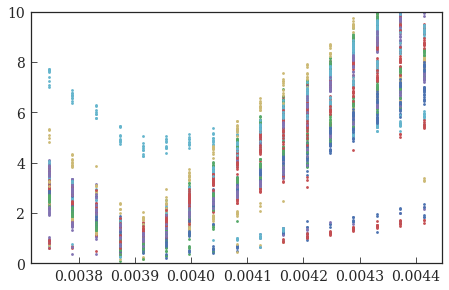

In [34]:
# sanity check 
for k in range(34):
    plt.plot(myDataFrame['logical_PI_KFA45.K.value'].shift(shiftVal),osc_amplitude[:,k],'.')
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0,10))

Beta_x at PR.BPM47: 22.56431942


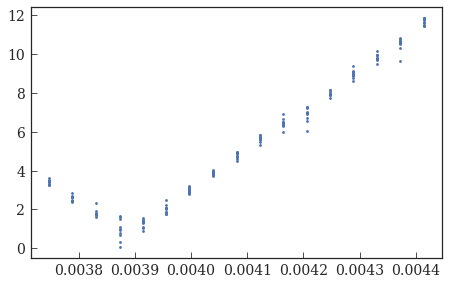

In [39]:
# manual inspection
bpm_n = 19
plt.plot(myDataFrame['logical_PI_KFA45.K.value'].shift(shiftVal),osc_amplitude[:,bpm_n],'.')
x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,0,10))
print 'Beta_x at '+BPM_name[bpm_n]+': '+str(BPM_betax[bpm_n])

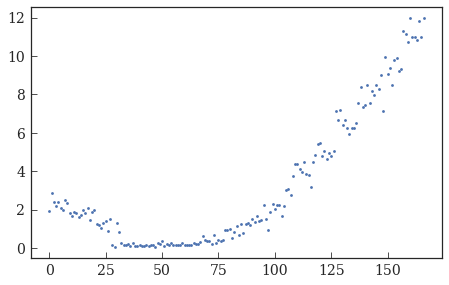

In [40]:
plt.plot(chi2[:,bpm_n],'.')

Text(0,0.5,u'Shot number')

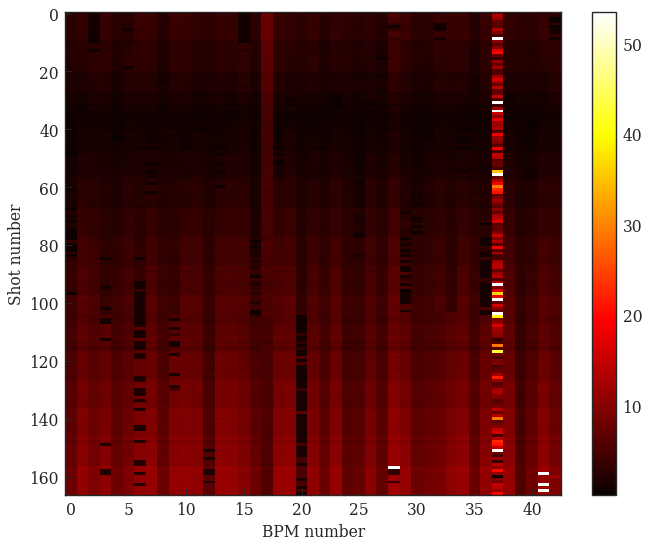

In [41]:
fig=plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(osc_amplitude[:,:],
           cmap='hot',
           aspect='auto'
          )
plt.colorbar()
plt.xlabel('BPM number')
plt.ylabel('Shot number')

## 2. RMS orbit deviation 1st-2nd turn and 1st turn-1ms orbit

### calculate the RMS orbit deviation
Use difference between the first and second turn to evaluate the orbit deviation from the reference orbit, where


$$\Delta x_\text{rms} =  \sqrt{\frac{1}{N} \sum_{i=1}^{N} (x_\text{turn2} - x_\text{turn1})^2 }$$


excluding the BPM in the bump, that would dominate the estimator.

Same for the deviation from the orbit 

$$\Delta x_\text{rms, orbit} = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (x_\text{turn1} - x_\text{average_orbit_1ms})^2 }$$

In [42]:
# X plane
mySeries1 = myDataFrame['BPMx_turn1'].apply(lambda x: np.delete(x,17))
mySeries2 = myDataFrame['BPMx_turn2'].apply(lambda x: np.delete(x,17))
# bad BPM
mySeries1 = mySeries1.apply(lambda x: np.delete(x,36))
mySeries2 = mySeries2.apply(lambda x: np.delete(x,36))

# myOrbit = myDataFrame['Orbit_x'].apply(lambda x: np.delete(x,17))

myDataFrame['deltaX_2turns'] = signalRMSDifference(mySeries1,mySeries2,42) # BPM43 excluded
# myDataFrame['OrbitX_dev_RMS'] = signalRMSDifference(mySeries1,myOrbit,42) # BPM43 excluded

# Y plane
mySeries1 = myDataFrame['BPMy_turn1'].apply(lambda x: np.delete(x,17))
mySeries2 = myDataFrame['BPMy_turn2'].apply(lambda x: np.delete(x,17))
#bad BPM
mySeries1 = mySeries1.apply(lambda x: np.delete(x,36))
mySeries2 = mySeries2.apply(lambda x: np.delete(x,36))
myOrbit = myDataFrame['Orbit_y'].apply(lambda x: np.delete(x,17))

# myDataFrame['deltaY_2turns'] = signalRMSDifference(mySeries1,mySeries2,42) # BPM43 excluded
# myDataFrame['OrbitY_dev_RMS'] = signalRMSDifference(mySeries1,myOrbit,42) # BPM43 excluded

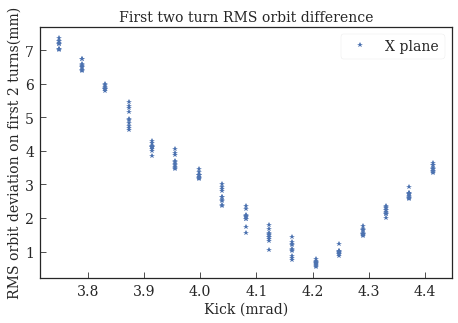

In [43]:
plt.plot(1e3*myDataFrame['logical_PI_KFA45.K.value'].shift(shiftVal),myDataFrame['deltaX_2turns'].values,'*',label='X plane')

plt.xlabel('Kick (mrad)')
plt.ylabel('RMS orbit deviation on first 2 turns(mm)')
plt.title('First two turn RMS orbit difference')

# plt.plot(1e3*myDataFrame['logical_PI_KFA45.K.value'].shift(shiftVal),myDataFrame['deltaY_2turns'].values,'*',label='Y plane')



plt.legend(frameon=True)
x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,0,8))
# plt.axvline(x=0.004381000000000, ymin=0, ymax = 8, linewidth=2, color='k')

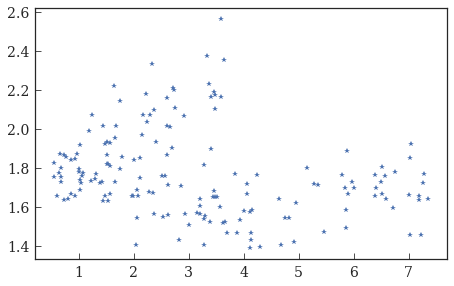

In [53]:
plt.plot(myDataFrame['deltaX_2turns'].values, myDataFrame['WS_geom_emittance_x'],'*',label='X plane')


In [44]:
xrms12_mean = np.array([ np.mean(myDataFrame['deltaX_2turns'].iloc[0:9]),
                      np.mean(myDataFrame['deltaX_2turns'].iloc[10:19]),
                      np.mean(myDataFrame['deltaX_2turns'].iloc[19:27]),
                      np.mean(myDataFrame['deltaX_2turns'].iloc[27:37]),
                      np.mean(myDataFrame['deltaX_2turns'].iloc[37:47]),
                      np.mean(myDataFrame['deltaX_2turns'].iloc[47:57]),
                      np.mean(myDataFrame['deltaX_2turns'].iloc[57:67]),
                      np.mean(myDataFrame['deltaX_2turns'].iloc[67:77]),
                      np.mean(myDataFrame['deltaX_2turns'].iloc[77:87]),
                      np.mean(myDataFrame['deltaX_2turns'].iloc[87:97]),
                      np.mean(myDataFrame['deltaX_2turns'].iloc[97:107]),
                      np.mean(myDataFrame['deltaX_2turns'].iloc[107:117]),
                      np.mean(myDataFrame['deltaX_2turns'].iloc[117:126]),
                      np.mean(myDataFrame['deltaX_2turns'].iloc[126:136]),
                      np.mean(myDataFrame['deltaX_2turns'].iloc[136:146]),
                      np.mean(myDataFrame['deltaX_2turns'].iloc[146:156]),
                      np.mean(myDataFrame['deltaX_2turns'].iloc[156:166]),
                    ])

xrms12_std = np.array([ np.std(myDataFrame['deltaX_2turns'].iloc[0:9]),
                      np.std(myDataFrame['deltaX_2turns'].iloc[10:19]),
                      np.std(myDataFrame['deltaX_2turns'].iloc[19:27]),
                      np.std(myDataFrame['deltaX_2turns'].iloc[27:37]),
                      np.std(myDataFrame['deltaX_2turns'].iloc[37:47]),
                      np.std(myDataFrame['deltaX_2turns'].iloc[47:57]),
                      np.std(myDataFrame['deltaX_2turns'].iloc[57:67]),
                      np.std(myDataFrame['deltaX_2turns'].iloc[67:77]),
                      np.std(myDataFrame['deltaX_2turns'].iloc[77:87]),
                      np.std(myDataFrame['deltaX_2turns'].iloc[87:97]),
                      np.std(myDataFrame['deltaX_2turns'].iloc[97:107]),
                      np.std(myDataFrame['deltaX_2turns'].iloc[107:117]),
                      np.std(myDataFrame['deltaX_2turns'].iloc[117:126]),
                      np.std(myDataFrame['deltaX_2turns'].iloc[126:136]),
                      np.std(myDataFrame['deltaX_2turns'].iloc[136:146]),
                      np.std(myDataFrame['deltaX_2turns'].iloc[146:156]),
                      np.std(myDataFrame['deltaX_2turns'].iloc[156:166]),
                    ])


<Container object of 3 artists>

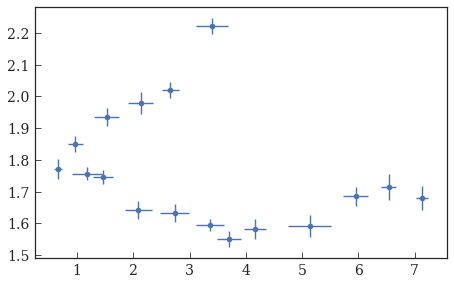

In [45]:
plt.errorbar(xrms12_mean, emix_mean, xerr=xrms12_std, yerr=emiy_std, fmt='o',label='emi_x')

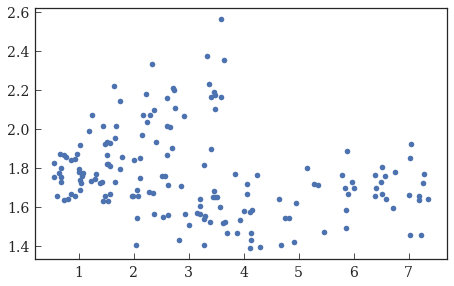

In [46]:
plt.plot(myDataFrame['deltaX_2turns'].values,myDataFrame['WS_geom_emittance_x'],'o')

In [47]:
plt.plot(1e3*myDataFrame['logical_PI_KFA45.K.value'].shift(shiftVal),myDataFrame['OrbitX_dev_RMS'].values,'*',label='X plane')

plt.xlabel('Kick (mrad)')
plt.ylabel('RMS orbit deviation 1st turn-orbit (mm)')
plt.title('First turn RMS orbit difference from closed orbit')

plt.plot(1e3*myDataFrame['logical_PI_KFA45.K.value'].shift(shiftVal),myDataFrame['OrbitY_dev_RMS'].values,'*',label='Y plane')


plt.legend(frameon=True)
x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,0,8))
# plt.axvline(x=0.004381000000000, ymin=0, ymax = 8, linewidth=2, color='k')

KeyError: 'OrbitX_dev_RMS'

# Methods comparison

## 1) Single BPM method

In [48]:
bpm_n1 = 21
osc1 = osc_amplitude[:,bpm_n1]
print 'At '+BPM_name[bpm_n1]+' betax='+str(BPM_betax[bpm_n1])+' alphax='+str(BPM_alphax[bpm_n1])
print 'Expected value for the fit a='+str((1+BPM_alphax[bpm_n1]**2)/(2*BPM_betax[bpm_n1]))
bpm_n2 = 21
osc2 = osc_amplitude[:,bpm_n2]
print 'At '+BPM_name[bpm_n2]+' betax='+str(BPM_betax[bpm_n2])+' alphax='+str(BPM_alphax[bpm_n2])
print 'Expected value for the fit a='+str((1+BPM_alphax[bpm_n2]**2)/(2*BPM_betax[bpm_n2]))

At PR.BPM53 betax=22.22678114 alphax=0.00066337
Expected value for the fit a=0.0224953949418
At PR.BPM53 betax=22.22678114 alphax=0.00066337
Expected value for the fit a=0.0224953949418


Model function: a(x)^2 + c
Fit params: a=0.00510980716364 c= 1.59061865489e-06
 
At PR.BPM53 betax=22.22678114 alphax=0.00066337
Expected value for the fit a=0.0224953949418


NameError: name 'emix_geom_PSB' is not defined

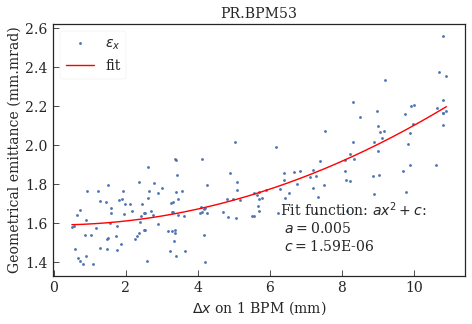

In [49]:
from scipy.optimize import curve_fit

def f_to_fit(x, a, c):
    return a*(x )**2 + c

xdata = 1e-3*osc1
ydata = 1e-6*myDataFrame['WS_geom_emittance_x']

fig, ax = plt.subplots(1)
ax.plot(1e3*xdata, 1e6*ydata,'.',label='$\epsilon_x$') #factors are to adjust units in the plot

p, cov = curve_fit(f_to_fit,xdata,ydata)

xfit = np.linspace(np.min(xdata),np.max(xdata),200)
ax.plot(1e3*xfit, 1e6*f_to_fit(xfit, *p), 'r-', label='fit') #factors are to adjust units in the plot

#fit and plot fit
print 'Model function: a(x)^2 + c'
print 'Fit params: a=' + str(p[0]) + ' c= '+ str(p[1])


plt.xlabel('$\Delta x$ on 1 BPM (mm)')
plt.ylabel('Geometrical emittance (mm.mrad)')
plt.title(BPM_name[bpm_n1])

ax.text(0.55, 0.3, 'Fit function: $ax^2+c$:\n $a=$%.3f \n $c=$%.2E'%(p[0],p[1]),
        transform=ax.transAxes, fontsize=14,verticalalignment='top')

x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,1.5,4.2))


plt.legend(frameon=True)
print ' '
print 'At '+BPM_name[bpm_n1]+' betax='+str(BPM_betax[bpm_n1])+' alphax='+str(BPM_alphax[bpm_n1])
print 'Expected value for the fit a='+str((1+BPM_alphax[bpm_n1]**2)/(2*BPM_betax[bpm_n1]))


ax.plot(xfit*1e3, 1e6*f_to_fit(xfit,((1+BPM_alphax[bpm_n1]**2)/(2*BPM_betax[bpm_n1])),emix_geom_PSB*1e-6),'-',label='model') #factors are to adjust units in the plot

plt.legend(frameon=True)


x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,1,2.5))

fig.savefig('single_BPM185.eps', format='eps')

Model function: a(x - b)^2 + c
Fit params: a=0.00489364273458 b= -0.000261283370386 c= 1.58498880034e-06
 
At PR.BPM53 betax=22.22678114 alphax=0.00066337
Expected value for the fit a=0.0224953949418
Theoretically a=(1+alpha^2)/2beta


NameError: name 'emix_geom_PSB' is not defined

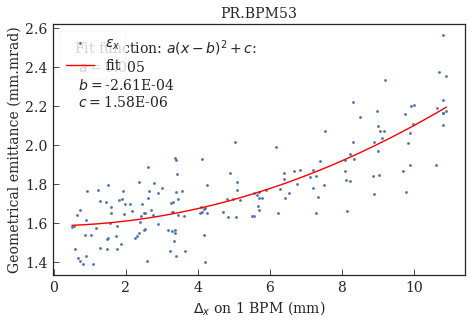

In [50]:
from scipy.optimize import curve_fit

def f_to_fit(x, a, b, c):
    return a*(x - b)**2 + c

xdata = 1e-3*osc2
ydata = 1e-6*myDataFrame['WS_geom_emittance_x']

fig, ax = plt.subplots(1)
ax.plot(1e3*xdata, 1e6*ydata,'.',label='$\epsilon_x$') #factors are to adjust units in the plot

p, cov = curve_fit(f_to_fit,xdata,ydata)

xfit = np.linspace(np.min(xdata),np.max(xdata),200)
ax.plot(1e3*xfit, 1e6*f_to_fit(xfit, *p), 'r-', label='fit') #factors are to adjust units in the plot

#fit and plot fit
print 'Model function: a(x - b)^2 + c'
print 'Fit params: a=' + str(p[0]) + ' b= ' + str(p[1]) + ' c= '+ str(p[2])


plt.xlabel('$\Delta_x$ on 1 BPM (mm)')
plt.ylabel('Geometrical emittance (mm.mrad)')
plt.title(BPM_name[bpm_n2])

ax.text(0.05, 0.95, 'Fit function: $a(x-b)^2+c$:\n $a=$%.3f \n $b=$%.2E \n $c=$%.2E'%(p[0],p[1],p[2]),
        transform=ax.transAxes, fontsize=14,verticalalignment='top')

x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,1.5,4.2))


plt.legend(frameon=True)
print ' '
print 'At '+BPM_name[bpm_n2]+' betax='+str(BPM_betax[bpm_n2])+' alphax='+str(BPM_alphax[bpm_n2])
print 'Expected value for the fit a='+str((1+BPM_alphax[bpm_n2]**2)/(2*BPM_betax[bpm_n2]))
print 'Theoretically a=(1+alpha^2)/2beta'

ax.plot(xfit*1e3, 1e6*f_to_fit(xfit,((1+BPM_alphax[bpm_n1]**2)/(2*BPM_betax[bpm_n1])),p[1],emix_geom_PSB*1e-6),'-',label='model') #factors are to adjust units in the plot

plt.legend(frameon=True)


x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,1,1.9))

fig.savefig('single_BPM185.eps', format='eps')

## 2) All BPM - single turn method

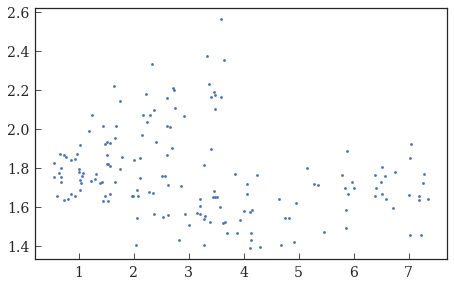

In [51]:
from scipy.optimize import curve_fit

def f_to_fit(x, a, c):
    return a*(x)**2 + c

xdata = 1e-3*myDataFrame['deltaX_2turns']
ydata = 1e-6*myDataFrame['WS_geom_emittance_x']

fig, ax = plt.subplots(1)
ax.plot(1e3*xdata, 1e6*ydata,'.',label='$\epsilon_x$') #factors are to adjust units in the plot

# p, cov = curve_fit(f_to_fit,xdata,ydata)

# xfit = np.linspace(np.min(xdata),np.max(xdata),200)
# ax.plot(1e3*xfit, 1e6*f_to_fit(xfit, *p), 'r-', label='fit') #factors are to adjust units in the plot

# #fit and plot fit
# print 'Model function: a(x)^2 + c'
# print 'Fit params: a=' + str(p[0]) + ' c= '+ str(p[1])


# plt.xlabel('$\Delta_{x,RMS}$ (mm)')
# plt.ylabel('Geometrical emittance (mm.mrad)')
# plt.title('First/second turn RMS difference')

# ax.text(0.05, 0.95, 'Fit function: $a(x-b)^2+c$:\n $a=$%.3f \n $c=$%.2E'%(p[0],p[1]),
#         transform=ax.transAxes, fontsize=14,verticalalignment='top')

# x1,x2,y1,y2 = plt.axis()
# # plt.axis((x1,x2,1.5,4.2))


# plt.legend(frameon=True)
# print ' '
# print 'Expected value for the fit a='+str(1./(2.*16.))


# ax.plot(xfit*1e3, 1e6*f_to_fit(xfit,(1./(2.*16.)),emix_geom_PSB*1e-6),'-',label='model') #factors are to adjust units in the plot

# plt.legend(frameon=True)


# x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,1,1.9))

# fig.savefig('all_BPM185.eps', format='eps')

In [ ]:
p[1]

In [ ]:
from scipy.optimize import curve_fit

def f_to_fit(x, a, b, c):
    return a*(x - b)**2 + c

xdata = 1e-3*myDataFrame['OrbitX_dev_RMS']
ydata = 1e-6*myDataFrame['WS_geom_emittance_x']

fig, ax = plt.subplots(1)
ax.plot(1e3*xdata, 1e6*ydata,'.',label='$\epsilon_x$') #factors are to adjust units in the plot

p, cov = curve_fit(f_to_fit,xdata,ydata)

xfit = np.linspace(np.min(xdata),np.max(xdata),200)
ax.plot(1e3*xfit, 1e6*f_to_fit(xfit, *p), 'r-', label='fit') #factors are to adjust units in the plot

#fit and plot fit
print 'Model function: a(x - b)^2 + c'
print 'Fit params: a=' + str(p[0]) + ' b= ' + str(p[1]) + ' c= '+ str(p[2])


plt.xlabel('$\Delta_{x,RMS}$ (mm)')
plt.ylabel('Geometrical emittance (mm.mrad)')
plt.title('First turn/orbit difference')

ax.text(0.35, 0.95, 'Fit function: $a(x-b)^2+c$:\n $a=$%.3f \n $b=$%.2E \n $c=$%.2E'%(p[0],p[1],p[2]),
        transform=ax.transAxes, fontsize=14,verticalalignment='top')

x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,1.5,4.2))


plt.legend(frameon=True)
print ' '
print 'Expected value for the fit a='+str(1./(2.*16.))

# Laslett tune shift calculation

In [ ]:
myDataFrame['peakLineDensity'] = 0.39

In [ ]:
# brightness and intensity
myDataFrame['WS_intensity'] = myDataFrame['Intensity'].apply(lambda x: x[80])
myDataFrame['Brightness'] = myDataFrame['WS_intensity']/(0.5*(myDataFrame['WS_emittance_x']+myDataFrame['WS_emittance_y']))

In [ ]:
twiss_file_name = '/eos/user/e/esenes/AnalysisTools/Injection7_optics_Qx_0.21_Qy_0.23_cycled_timefalse.outx'

[deltaQx, deltaQy] = laslett_sc_PS(myDataFrame['peakLineDensity'], myDataFrame['deltaP_P_rms'],
              1e-6*myDataFrame['WS_emittance_x'], 1e-6*myDataFrame['WS_emittance_y'],
              1400, twiss_file_name)

myDataFrame['deltaQx'] = deltaQx
myDataFrame['deltaQy'] = deltaQy

In [ ]:
fig, ax = plt.subplots(1)

# working point
Qx = 6.207
Qy = 6.155
plt.plot(Qx,Qy,'r.',markersize=10)

# tune diagram lines
ax.plot([5.8, 6.3],[5.8, 6.3],'k')
ax.plot([6, 6],[5.8, 6.3],'k')
ax.plot([5.8, 6.3],[6, 6],'k')
ax.plot([6.25, 6.25],[5.8, 6.3],'k')
ax.plot([5.8, 6.3],[6.25, 6.25],'k')
# options
plt.xlim([6.1, 6.26])
plt.ylim([6.05, 6.26])
# tune shifts


p1 = ax.scatter(Qx+myDataFrame['deltaQx'], Qy+myDataFrame['deltaQy'], c=myDataFrame['Brightness'], cmap=plt.cm.coolwarm)
clb = fig.colorbar(p1)
clb.set_label('Beam brightness')

# PSB point
[deltaQxPSB, deltaQyPSB] = laslett_sc_PS(0.39, 0.5e-3,
              1e-6*2.312, 1e-6*2.143,
              1400, twiss_file_name)
plt.plot(Qx+deltaQxPSB,Qy+deltaQyPSB,'*',markersize=15)


plt.show()

fig.savefig('BCMS_under_coupling_footprint.eps', format='eps')

In [ ]:
--> fix the peak line density in the tomogram function
--> Turn your library into a class, define the methods as static methods and change all the callers as eTools.functionNaME()
--> implementa il local indexing instaed of the iloc in the dataframe